In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import os
from PIL import Image
#pip install opencv-python (for cv2)

In [3]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
])

In [4]:
# Load datasets
train_dataset = datasets.ImageFolder(root='/users/edatkinson/LLL/split_classes/train/', transform=transform)

val_dataset = datasets.ImageFolder(root='/users/edatkinson/LLL/split_classes/validation/', transform=transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
#how to reduce the amount of images loaded from a specific class

In [5]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(2, 2)  # Adding pooling layer
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(2, 2)  # Adding pooling layer
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(2, 2)  # Adding pooling layer
        
        # After 3 rounds of halving the dimensions, the size calculation needs adjustment
        # For an input of 224x224, after three poolings, the size is 224 / 2 / 2 / 2 = 28
        self.fc1_size = 64 * 28 * 28  # Adjusted based on the pooling layers
        self.fc1 = nn.Linear(self.fc1_size, 500)
        self.fc2 = nn.Linear(500, 6)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))  # Apply pooling
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))  # Apply pooling
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))  # Apply pooling
        x = x.view(-1, self.fc1_size)  # Flatten the output for the fully connected layer
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [6]:
# Create the model, loss function, and optimizer
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-6)

In [7]:
# Train the model
n_epochs = 3
for epoch in range(n_epochs):
    train_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
    train_loss = train_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{n_epochs}, Training Loss: {train_loss}")

Epoch 1/3, Training Loss: 0.7240913696138618
Epoch 2/3, Training Loss: 0.14934632029281136
Epoch 3/3, Training Loss: 0.15581595937223977


In [8]:
#Evaluate the model
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Validation Accuracy: {100 * correct / total}%")

Validation Accuracy: 91.81286549707602%


In [9]:
# Test over the test set

test_dataset = datasets.ImageFolder(root='/users/edatkinson/LLL/split_classes/test/', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Test Accuracy: {100 * correct / total}%")

Test Accuracy: 91.38686131386861%


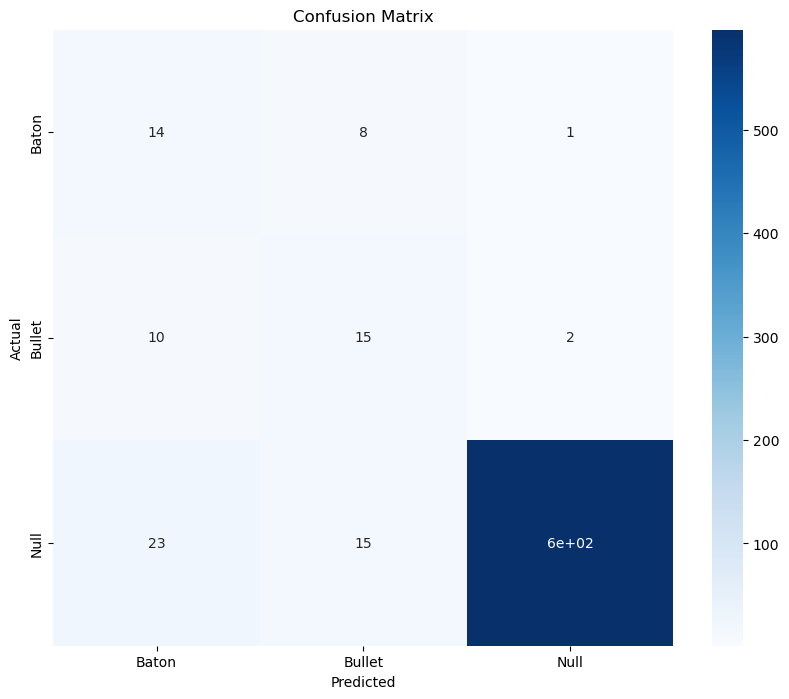

In [10]:
#This cell is for the confusion matrix 

from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true += labels.tolist()
        y_pred += predicted.tolist()

# Update the classes to include all the classes present in the confusion matrix
classes = ['Baton', 'Bullet', 'Null']

cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=classes, columns=classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()